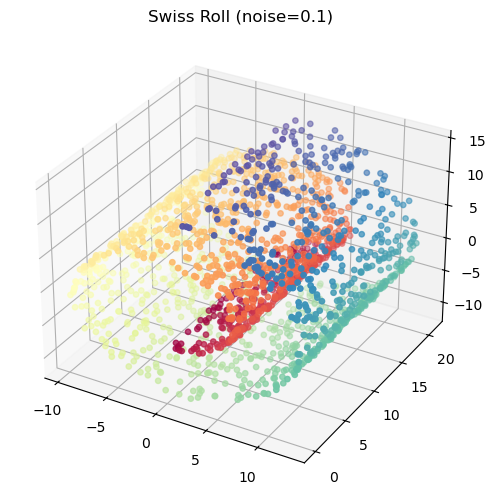

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_swiss_roll
from functorch import jacrev, vmap

device = 'cuda' if torch.cuda.is_available() else 'mps'


# 1) Generate Swiss Roll data
n_samples = 2000
X_swiss, color_t = make_swiss_roll(n_samples=n_samples, noise=0.1)
X_swiss = X_swiss.astype(np.float32)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_swiss[:,0], X_swiss[:,1], X_swiss[:,2],
           c=color_t, cmap='Spectral', s=15)
ax.set_title("Swiss Roll (noise=0.1)")
plt.show()

# Turn into a PyTorch dataset/dataloader
tensor_x = torch.from_numpy(X_swiss).to(device)
dset = TensorDataset(tensor_x)
dloader = DataLoader(dset, batch_size=128, shuffle=True)

In [2]:

# 2) Define a small MLP with residual blocks & Softplus
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.act     = nn.Softplus()
        self.linear2 = nn.Linear(dim, dim)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.act(out)
        out = self.linear2(out)
        return x + out  # Residual connection

class ScoreNet(nn.Module):
    def __init__(self, dim=3, hidden_dim=64, n_res_blocks=3):
        super().__init__()
        self.input = nn.Linear(dim, hidden_dim)
        self.act   = nn.Softplus()
        
        self.resblocks = nn.ModuleList([
            ResidualBlock(hidden_dim) for _ in range(n_res_blocks)
        ])
        
        self.output = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        h = self.input(x)
        h = self.act(h)
        for block in self.resblocks:
            h = block(h)
            h = self.act(h)
        return self.output(h)  # shape: (batch_size, dim)




In [3]:

def sliced_score_matching_loss(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    """
    Implements the Sliced Score Matching objective in an unnormalized way:
      E_v [ 0.5 * (v^T s_theta(x))^2 + v^T J(x) v ]
    where v ~ N(0, I).
    """
    # Forward pass: s(x)
    s = model(x)  # shape (batch_size, d)
    
    # Sample random direction v ~ N(0,I) (no normalization)
    v = torch.randn_like(s)
    
    # First term: 0.5 * (v^T s)^2
    vs = torch.sum(v * s, dim=-1)   # (batch_size,)
    term1 = 0.5 * (vs ** 2)
    
    # Second term: v^T (Jacobian of s) v
    # We'll use functorch to compute the Jacobian for each sample
    J = vmap(jacrev(model))(x)      # shape: (batch_size, d, d)
    term2 = torch.einsum('bi,bij,bj->b', v, J, v)
    
    # Final objective is the average over the batch
    loss = (term1 + term2).mean()
    return loss



score_net = ScoreNet(dim=3, hidden_dim=64, n_res_blocks=3).to(device)
optimizer = torch.optim.Adam(score_net.parameters(), lr=1e-3)

num_epochs = 2000
print_every = 200

score_net.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    n_data = 0
    for (batch_x,) in dloader:
        optimizer.zero_grad()
        loss = sliced_score_matching_loss(score_net, batch_x)
        loss.backward()
        optimizer.step()
        
        bs = batch_x.shape[0]
        total_loss += loss.item() * bs
        n_data += bs
    
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1:4d}: Loss = {total_loss/n_data:.6f}")




/var/folders/5m/w0rlpsxd7yx_97nl1gx0dfzm0000gn/T/ipykernel_14785/2776387648.py:19: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  J = vmap(jacrev(model))(x)      # shape: (batch_size, d, d)
/var/folders/5m/w0rlpsxd7yx_97nl1gx0dfzm0000gn/T/ipykernel_14785/2776387648.py:19: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  J = vmap(

Epoch  200: Loss = -13.102837
Epoch  400: Loss = -30.304962
Epoch  600: Loss = -34.876686
Epoch  800: Loss = -41.510481
Epoch 1000: Loss = -33.099071
Epoch 1200: Loss = -32.417422
Epoch 1400: Loss = -36.517258
Epoch 1600: Loss = -42.007159
Epoch 1800: Loss = -42.001668
Epoch 2000: Loss = -52.911525


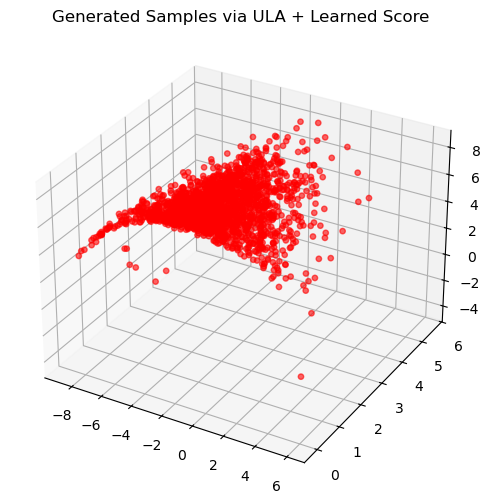

In [4]:

@torch.no_grad()
def generate_samples(score_model, n_samples=1000, n_steps=1000, eps=1e-3):
    """
    Sample from the learned distribution using
    Unadjusted Langevin Algorithm (ULA):
      x_{k+1} = x_k + eps * s_theta(x_k) + sqrt(2 eps) * z_k
    """
    score_model.eval()
    x = torch.randn(n_samples, 3, device=device)
    
    for _ in range(n_steps):
        z = torch.randn_like(x)
        grad_logp = score_model(x)  # score
        x = x + eps * grad_logp + torch.sqrt(torch.tensor(2*eps, device=device)) * z

    return x.detach().cpu().numpy()


# 6) Generate samples and plot
gen_samples = generate_samples(score_net, n_samples=2000, n_steps=1000, eps=1e-3)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(gen_samples[:,0], gen_samples[:,1], gen_samples[:,2],
           s=15, alpha=0.6, c='red')
ax.set_title("Generated Samples via ULA + Learned Score")
plt.show()
